### Analysis of Transcriptional Regulation of Glycogenes

#### Load data and prepare TF-gene interaction matrix

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import fisher_exact

figDir = './figures/'

# Read data
df = pd.read_csv('./mi_results.txt', delimiter='\t')

# Generate the interaction matrix for hierarchical clustering
interaction_matrix = df.pivot(index='Glycogene', columns='TF', values='MI')
interaction_matrix.fillna(0, inplace=True)
interaction_matrix_log = np.log1p(interaction_matrix) 

#### Perform hierachical clustering

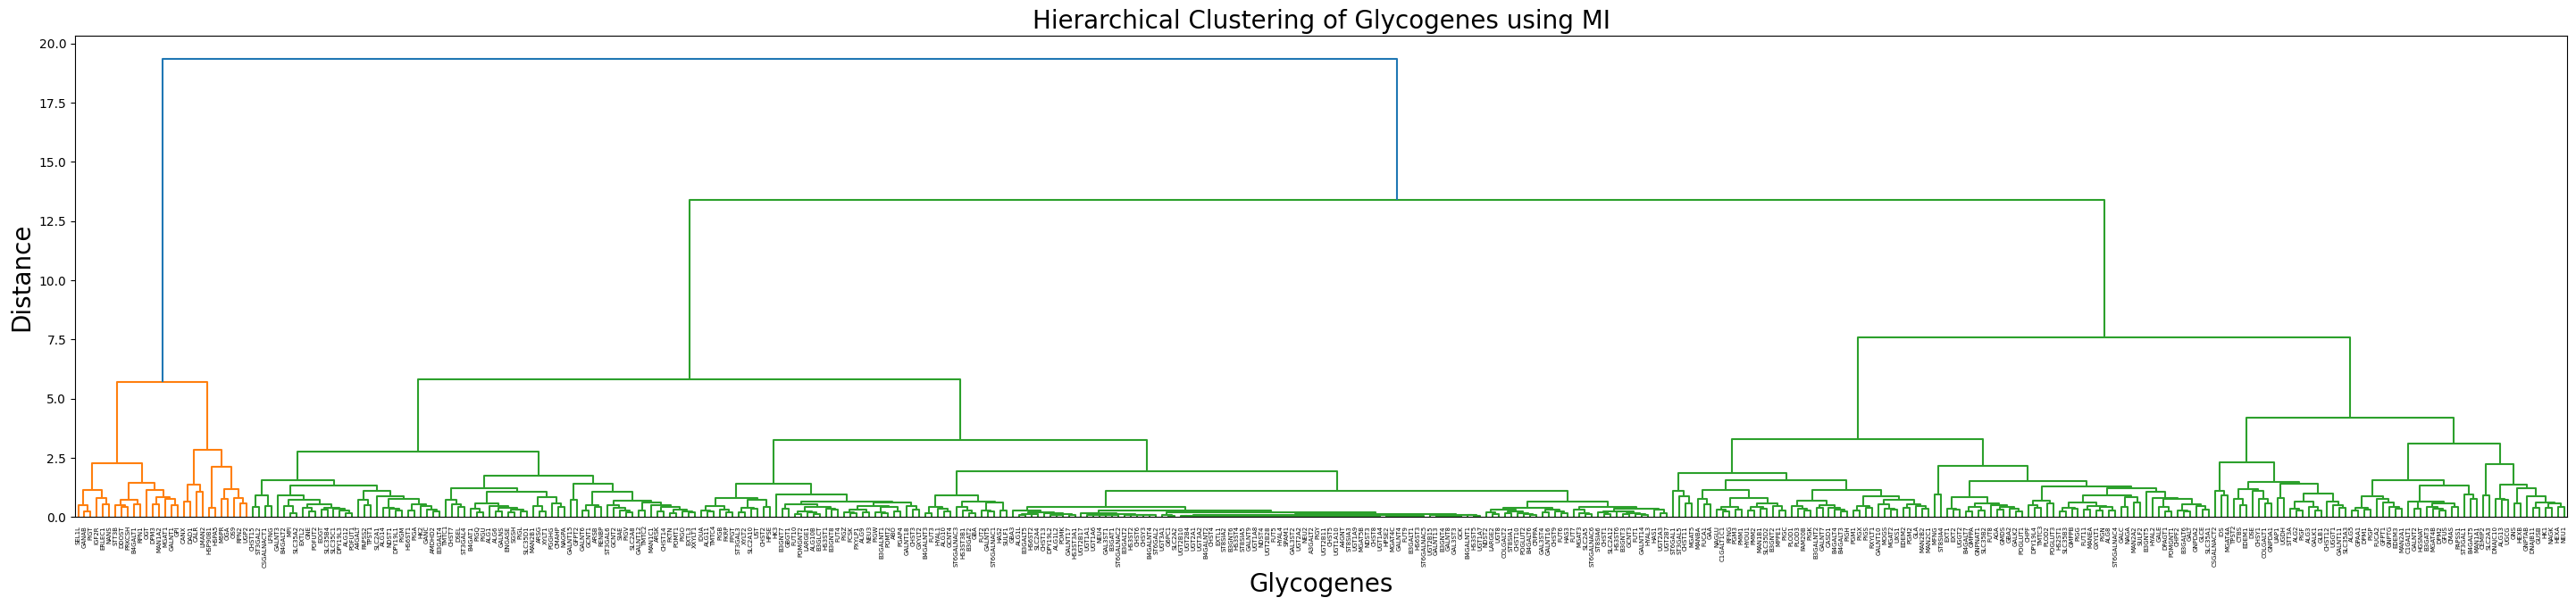

In [2]:
# Plot dendrogram for hierarchical clustering
linked = linkage(interaction_matrix_log, method='complete', metric='euclidean')
plt.figure(figsize=(36, 7))
dendrogram(linked, labels=interaction_matrix_log.index, orientation='top')
plt.title('Hierarchical Clustering of Glycogenes using MI', fontsize = 20)
plt.xlabel('Glycogenes', fontsize = 20)
plt.ylabel('Distance', fontsize = 20)
plt.show()


Number of glycogenes in Cluster 1 =  28
Number of glycogenes in Cluster 2 =  72
Number of glycogenes in Cluster 3 =  156
Number of glycogenes in Cluster 4 =  87
Number of glycogenes in Cluster 5 =  57


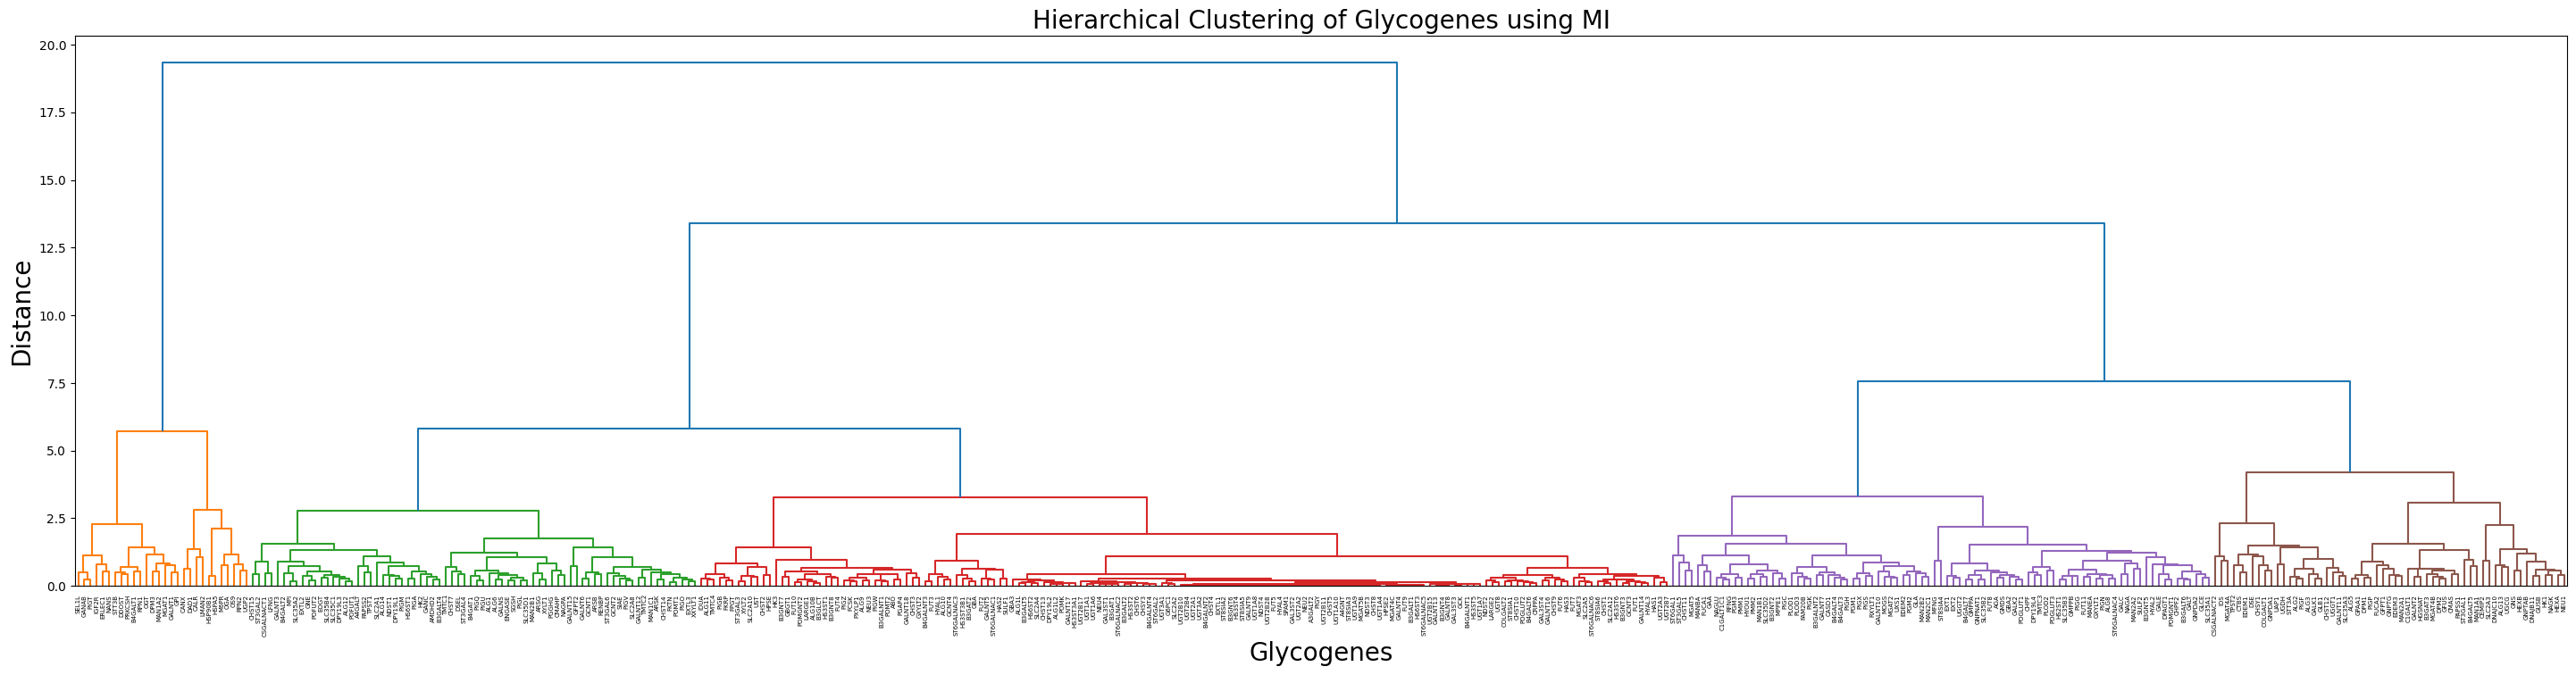

In [3]:
# Perform clustering 
num_clusters = 5 #based on visual inspection of dendrogram
gene_cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# Compile genes in clusters
gene_cluster_df = pd.DataFrame({'cluster': gene_cluster_labels}, index=interaction_matrix_log.index)
cluster_groups = gene_cluster_df.groupby('cluster')

gene_clusters = {}
for cluster, group_data in cluster_groups:
    gene_clusters[cluster] = group_data.index.tolist()
    print(f'Number of glycogenes in Cluster {cluster} = ', len(gene_clusters[cluster]))

# Save gene clusters
cluster_gene_df = pd.DataFrame(dict([(f'Cluster {k}', pd.Series(v)) for k, v in gene_clusters.items()]))
excel_filename = 'Gene_Clusters.xlsx'
cluster_gene_df.to_excel(excel_filename, index=False)    
    
# Plot the dendrogram 
distance_threshold = linked[-(num_clusters-1), 2]
plt.figure(figsize=(36, 8))
dendrogram(linked, labels=interaction_matrix_log.index, orientation='top', color_threshold=distance_threshold)
plt.title('Hierarchical Clustering of Glycogenes using MI', fontsize=20)
plt.xlabel('Glycogenes', fontsize=20)
plt.ylabel('Distance', fontsize=20)

# Save and display the figure
plt.savefig(''.join([figDir, "HierachicalClustering.png"]), dpi=600)
plt.show()

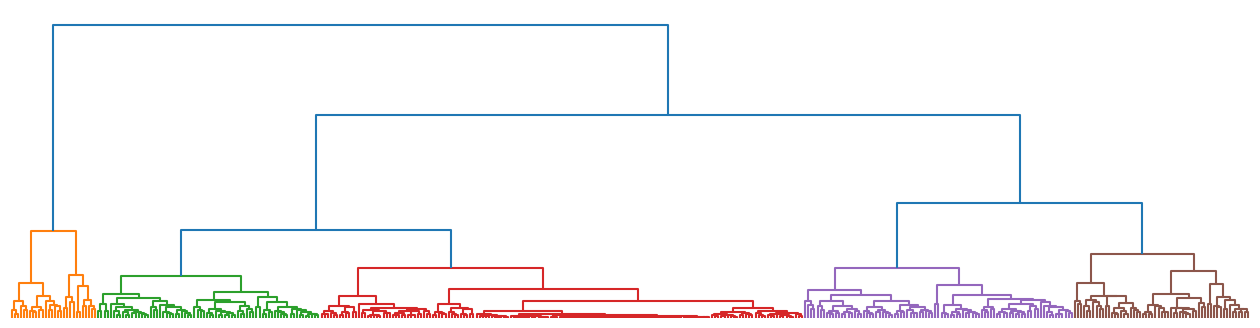

In [4]:
# Plot the dendrogram
plt.figure(figsize=(16, 4))
dendrogram(linked, labels=None, orientation='top', color_threshold=distance_threshold, no_labels=True)

# Format dendrogram
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tick_params(
    axis='both',       # Apply to both x and y axes
    which='both',      # Both major and minor ticks
    bottom=False,      # Remove bottom ticks
    top=False,         # Remove top ticks
    left=False,        # Remove left ticks
    labelbottom=False, # Remove bottom labels
    labelleft=False    # Remove left labels
)

# Save and display dendrogram
plt.savefig(''.join([figDir, "Dendrogram.png"]), dpi=600)
plt.show()

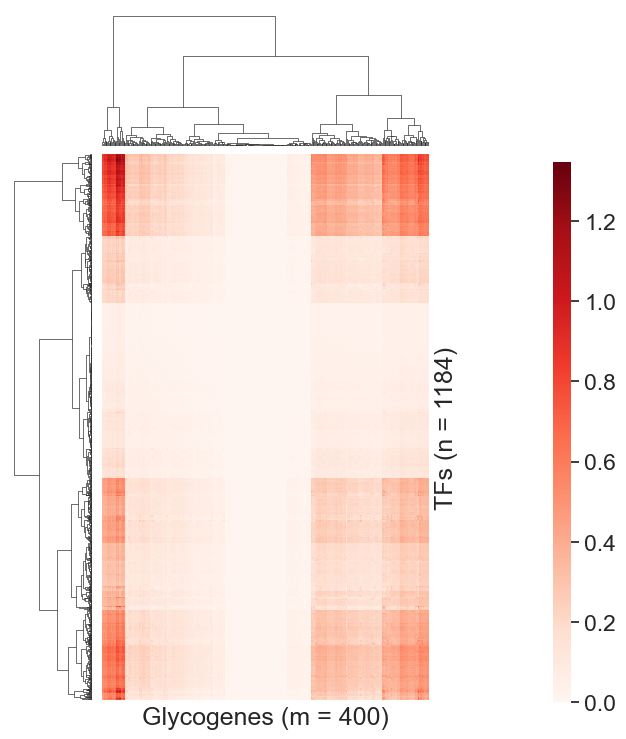

In [5]:
# Transpose the interaction matrix (columns: glycogenes, rows: TFs)
transposed_matrix = interaction_matrix_log.T

# Prepare heatmap
sns.set(font_scale=1.5)
cg_log = sns.clustermap(transposed_matrix, cmap='Reds', figsize=(6, 9), method='complete', metric='euclidean')
cg_log.ax_heatmap.set_xlabel('Glycogenes (m = ' + str(len(set(df['Glycogene']))) + ')')
cg_log.ax_heatmap.set_ylabel('TFs (n = ' + str(len(set(df['TF']))) + ')')
cg_log.ax_heatmap.xaxis.set_ticklabels([])
cg_log.ax_heatmap.xaxis.set_ticks([])
cg_log.ax_heatmap.yaxis.set_ticklabels([])
cg_log.ax_heatmap.yaxis.set_ticks([])
plt.setp(cg_log.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg_log.cax.set_position([0.95, 0.2, 0.03, 0.6])  # [left, bottom, width, height] in figure coordinate

# Save and display heatmap
plt.savefig(figDir + 'Heatmap.png', dpi=300)
plt.show()

# Reset font scaling
sns.set(font_scale=1.0)

#### Perform glycopathway enrichment analysis

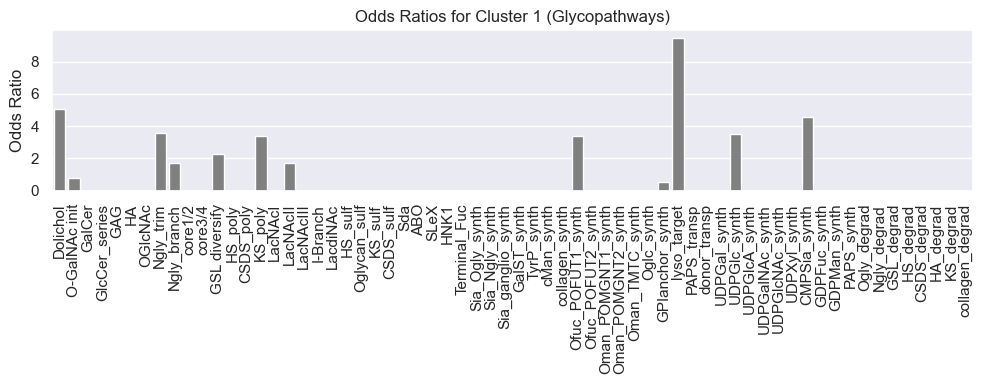

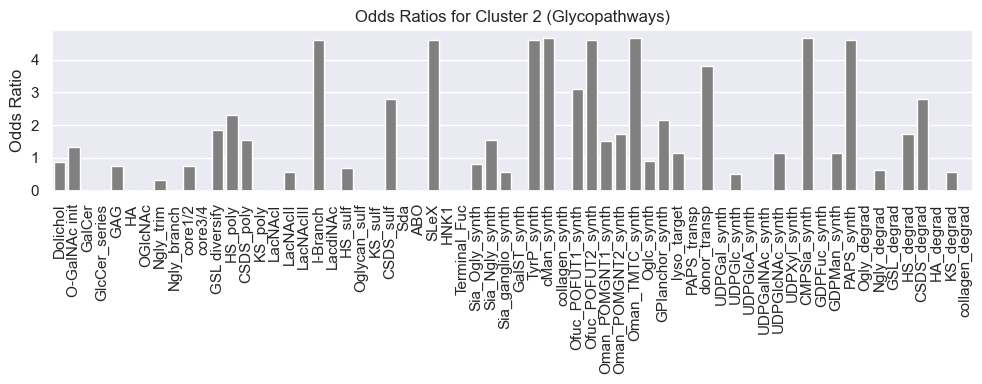

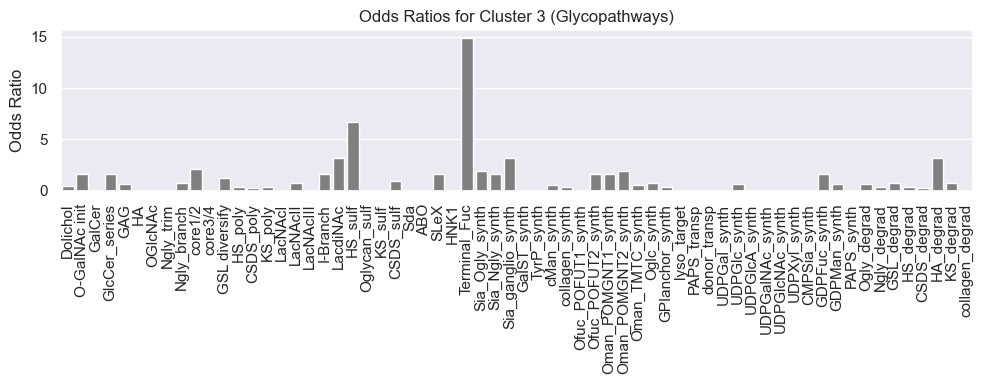

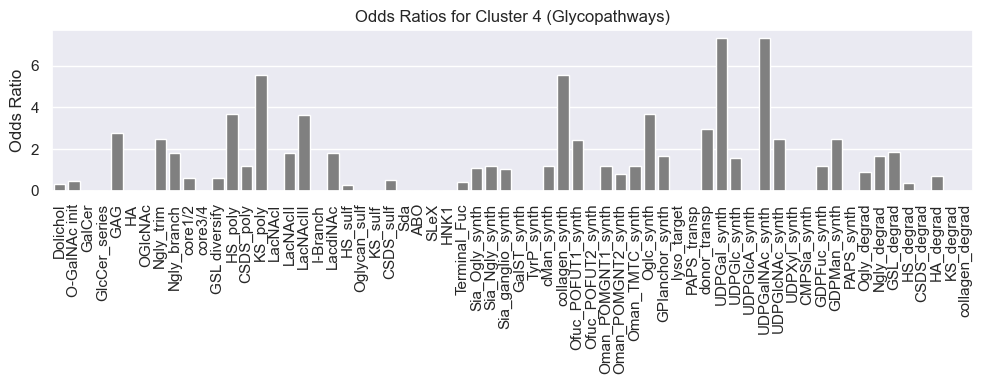

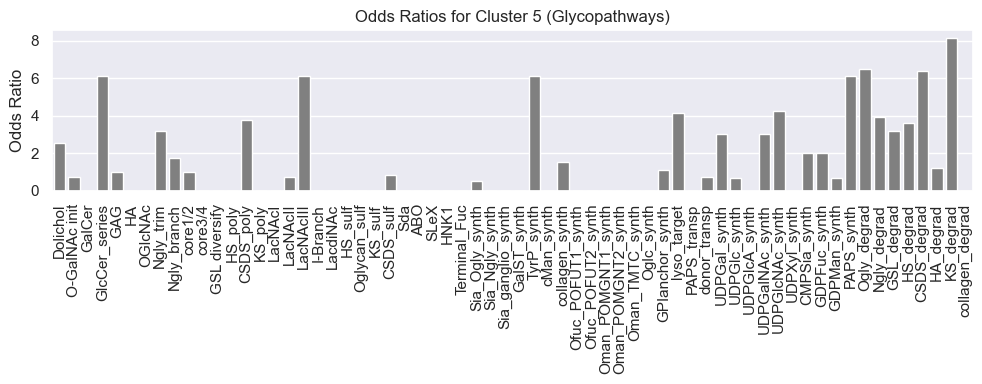

In [6]:
# Set statistical significance cutoff
alpha = 0.1

# Total glycogenes in the TS dataset
n = len(df['Glycogene'].unique())

# Load glycopathway gene sets
pathways_df = pd.read_excel('./glycopathways.xlsx', header=None)

# Get glycogenes
glycogenes_set = set(df['Glycogene'])

# Initialize dictionaries for p-values and odds ratios
p_values = {}
odds_ratios = {}

# Perform Fisher's Exact Test for each glycopathway
for index, row in pathways_df.iterrows():
    pathway_class = row[0]
    pathway_name = row[1]
    pathway_genes = row[2:].dropna().tolist()
    
    p_values[pathway_name] = {}
    odds_ratios[pathway_name] = {}
    
    for cluster, genes in gene_clusters.items():
        k = len(set(pathway_genes))
        m = len(genes)
        x = len(set(pathway_genes) & set(genes))
        contingency_table = [[x, k - x], [m - x, n - (m + k - x)]]
        odds_ratio, p_val = fisher_exact(contingency_table)
        
        p_values[pathway_name][cluster] = p_val
        odds_ratios[pathway_name][cluster] = odds_ratio
        
# Sort p-values
p_values_list = [(pathway, cluster, p) for pathway, clusters in p_values.items() for cluster, p in clusters.items()]
p_values_sorted = sorted(p_values_list, key=lambda x: x[2])

# Apply Benjamini-Hochberg procedure
num_tests = len(p_values_sorted)
bh_thresholds = [i/num_tests*alpha for i in range(1, num_tests+1)]
significant_p_values = {pathway: {cluster: False for cluster in gene_clusters} for pathway in p_values}
for (pathway, cluster, p), threshold in zip(p_values_sorted, bh_thresholds):
    if p < threshold:
        significant_p_values[pathway][cluster] = True
        
# Plot odds ratio
p_values_df = pd.DataFrame(p_values)
odds_ratios_df = pd.DataFrame(odds_ratios)        
for cluster in gene_clusters.keys():
    plt.figure(figsize=(10, 4))
    cluster_odds_ratios = odds_ratios_df.loc[cluster]
    cluster_p_values = p_values_df.loc[cluster]
    colors = ['b' if significant_p_values[pathway][cluster] else 'gray' for pathway in cluster_p_values.index]
    sns.barplot(x=cluster_odds_ratios.index, y=cluster_odds_ratios, palette=colors)
    plt.xticks(rotation=90)
    plt.ylabel('Odds Ratio')
    plt.title(f'Odds Ratios for Cluster {cluster} (Glycopathways)')
    plt.tight_layout()
    plt.savefig(''.join([figDir, f'Odds Ratios for Cluster {cluster} (Glycopathways).png']), dpi=300)
    plt.show()


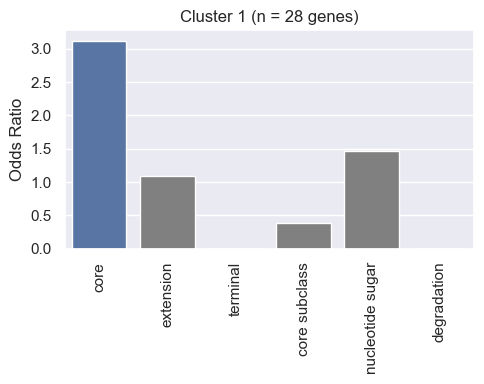

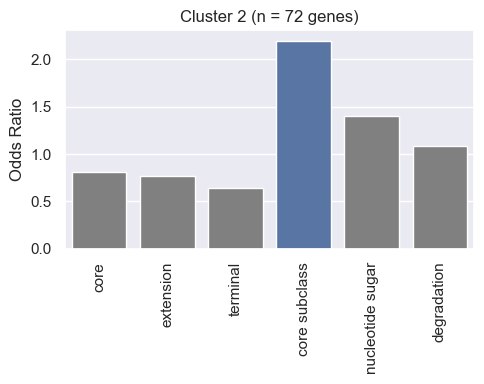

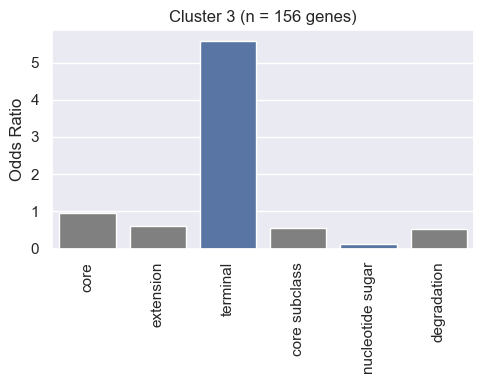

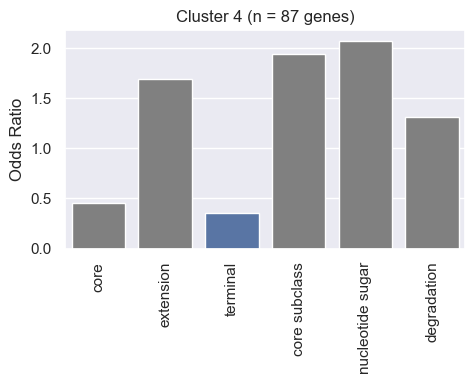

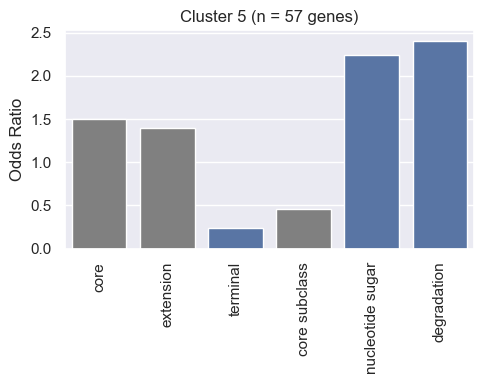

In [7]:
# Perform glycopathway class enrichment analysis
# Statistical significance cutoff
alpha = 0.1

# Initialization
p_values_class = {}
odds_ratios_class = {}
class_genes = {}

# Get genes in each glycopathway class
for pathway_class in pathways_df[0].unique():
    class_df = pathways_df[pathways_df[0] == pathway_class]
    aggregated_genes = set(class_df.iloc[:, 2:].values.flatten())
    aggregated_genes.discard(np.nan)  # Remove any NaNs from the set
    class_genes[pathway_class] = aggregated_genes
    
# Fisher's Exact Test
for pathway_class, aggregated_genes in class_genes.items():
    p_values_class[pathway_class] = {}
    odds_ratios_class[pathway_class] = {}
    
    for cluster, genes in gene_clusters.items():
        k = len(aggregated_genes)
        m = len(genes)
        x = len(aggregated_genes & set(genes))
        
        contingency_table = [[x, k - x], [m - x, n - (m + k - x)]]        
        odds_ratio, p_val = fisher_exact(contingency_table)
        
        p_values_class[pathway_class][cluster] = p_val
        odds_ratios_class[pathway_class][cluster] = odds_ratio

#Sort p-values
p_values_list = [(pathway_class, cluster, p) for pathway_class, clusters in p_values_class.items() for cluster, p in clusters.items()]
p_values_sorted = sorted(p_values_list, key=lambda x: x[2])

# Apply Benjamini-Hochberg procedure
num_tests = len(p_values_sorted)
bh_thresholds = [i/num_tests*alpha for i in range(1, num_tests+1)]
significant_p_values = {pathway_class: {cluster: False for cluster in gene_clusters} for pathway_class in p_values_class}
for (pathway_class, cluster, p), threshold in zip(p_values_sorted, bh_thresholds):
    if p < threshold:
        significant_p_values[pathway_class][cluster] = True
        
# Plot odds ratio
p_values_class_df = pd.DataFrame(p_values_class)
odds_ratios_class_df = pd.DataFrame(odds_ratios_class)

for cluster in gene_clusters.keys():
    plt.figure(figsize=(5, 4))
    
    cluster_odds_ratios = odds_ratios_class_df.loc[cluster]
    cluster_p_values = p_values_class_df.loc[cluster]
    num_genes_in_cluster = len(gene_clusters[cluster])  # Number of genes in the current cluster
    
    colors = ['b' if significant_p_values[pathway_class][cluster] else 'gray' for pathway_class in cluster_p_values.index]
    
    sns.barplot(x=cluster_odds_ratios.index, y=cluster_odds_ratios, palette=colors)
    plt.xticks(rotation=90)
    plt.ylabel('Odds Ratio')
    plt.title(f'Cluster {cluster} (n = {num_genes_in_cluster} genes)')
    plt.tight_layout()
    plt.savefig(''.join([figDir, f'Odds_Ratios_for_Cluster_{cluster}.png']), dpi=300)
    plt.show()

#### Identify significant TFs for each cluster

In [8]:
# Assign cluster labels to the interaction matrix
interaction_matrix_labeled = interaction_matrix_log.copy()
interaction_matrix_labeled['Cluster'] = gene_cluster_df['cluster']

# Initialize a DataFrame to store the sorted list of TFs for each cluster
tfs_df = pd.DataFrame()

# Process each cluster
for cluster in gene_clusters.keys():
    # Extract data for this cluster
    cluster_data = interaction_matrix_labeled[interaction_matrix_labeled['Cluster'] == cluster].drop('Cluster', axis=1)
    
    # Rank TFs for each gene in the cluster
    ranked_tfs = cluster_data.rank(axis=1, method='average', ascending=False)

    # Compute the average rank of each TF
    ranked_tfs = ranked_tfs.mean()

    # Sort TFs by their average rank and extract the TF names
    ranked_tfs = ranked_tfs.sort_values().index.tolist()

    # Add the sorted TF names to the DataFrame under the respective cluster column
    tfs_df[f'TF_{cluster}'] = pd.Series(ranked_tfs)

# Display the top 25 of the DataFrame
tfs_df.reset_index(drop=True, inplace=True)
print(tfs_df.head(25))

# Save to Excel
excel_path = './TFs_by_Clusters.xlsx'
tfs_df.to_excel(excel_path, index=False)

       TF_1     TF_2     TF_3     TF_4     TF_5
0       SON    TCF25     BRD4    TCF25      SON
1    HNRNPK    UBE2I    SSU72    UBE2I    TCF25
2     RBM39      YY1  CSNK2A1      YY1    RBM39
3     SRSF3    SSU72  SNRNP70    SSU72   HNRNPK
4     PCBP2    XRCC5    PTBP1    XRCC5    XRCC5
5     TCF25  SNRNP70    SRSF4      SON    UBE2I
6     PCBP1   ZNF207    MIER1    RBM39    PCBP1
7     SUMO2    NCOR1    UBE2I    NCOR1    PCBP2
8     XRCC5    RBM25     FXR1    RBM25    SRSF3
9       FUS     BRD4    EWSR1  SNRNP70      YY1
10     SFPQ    SRSF4    ASH1L   HNRNPK  HNRNPH1
11  HNRNPH1    SUMO1     TOX4  HNRNPH1     SFPQ
12    UBE2I      SON     XRN2   ZNF207      FUS
13    RBM25     ATF4     MBD2     SFPQ    RBM25
14      DEK     NONO    SUMO1     ATF4    SSU72
15    STAT3    RBM39    NCOR1     BRD4    SUMO2
16      YY1   BCLAF1     NONO    SRSF4    STAT3
17    SRSF7  HNRNPH1   GTF2A2    PCBP1   ZNF207
18    SSU72   HNRNPK    ZNF24    PCBP2    NCOR1
19    HMGB1    STAT3      YY1    SUMO1  